## L&T EduTech Hackathon: Problem Statement 1
Deep Learning framework for Crack Detection

In [ ]:
import os
import numpy as np
from glob import glob

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow_addons.metrics import F1Score

import matplotlib.pyplot as plt

In [ ]:
# Config Variables
DIR = "./Surface Crack" # Replace with Path to Data Folder

## Load Data

In [ ]:
def get_labels(ds):
    # Concatenate all the labels (2nd element in ds tuple)
    return np.concatenate([ex[1] for ex in ds.as_numpy_iterator()])

In [ ]:
def load_images(directory, subset, batch_size=32, image_size=(224, 224), shuffle=False):
    directory = os.path.join(directory, subset)
    return image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        class_names=['Negative','Positive'],
        color_mode="rgb",
        batch_size=batch_size,
        image_size=image_size,
        shuffle=shuffle,
    ).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# No shuffling to preserve order
train_ds_labels = get_labels(load_images(DIR, 'train'))
val_ds_labels = get_labels(load_images(DIR, 'valid'))
test_ds_labels = get_labels(load_images(DIR, 'test'))

Found 600 files belonging to 2 classes.
Number of training samples: (600,)
Found 200 files belonging to 2 classes.
Number of validation samples: (200,)
Found 200 files belonging to 2 classes.
Number of testing samples: (200,)


## Deep Learning Model

In [ ]:
def create_model(dim, name):
    return tf.keras.Sequential([
        tf.keras.Input(shape=(dim,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ], name+"_Model")

In [ ]:
history_dict = {}
for i, path in enumerate(glob("/content/Surface Crack/embeddings/*"), 1):
    name = path.rsplit('/',maxsplit=1)[1].replace('.npz','')
    
    with np.load(path) as data:
        model = create_model(data['train'].shape[1], name)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), F1Score(1, 'micro', threshold=0.5)],
        )

        epochs = 20
        history = model.fit(
            data['train'], train_ds_labels, epochs=epochs, 
            validation_data=(data['val'], val_ds_labels), 
            verbose=0, shuffle=True
        )
        history_dict[name] = history
        h = history.history
    print(f"{i}:{name} - val_loss:{min(h['val_loss'])} - val_precision:{max(h['val_precision'])} - val_recall:{max(h['val_recall'])} - val_f1_score:{max(h['val_f1_score'])}")

1:RegNetX080 - val_loss:0.561967134475708 - val_precision:0.9523809552192688 - val_recall:0.9399999976158142 - val_f1_score:0.7804878354072571
2:EfficientNetB1 - val_loss:0.5398264527320862 - val_precision:0.936170220375061 - val_recall:0.9300000071525574 - val_f1_score:0.8163265585899353
3:DenseNet121 - val_loss:0.08480266481637955 - val_precision:0.9801980257034302 - val_recall:0.9900000095367432 - val_f1_score:0.9850746393203735
4:ResNetRS101 - val_loss:0.6049858331680298 - val_precision:0.942307710647583 - val_recall:0.9100000262260437 - val_f1_score:0.8021978735923767
5:EfficientNetV2B2 - val_loss:0.549755334854126 - val_precision:0.939393937587738 - val_recall:0.949999988079071 - val_f1_score:0.7909090518951416
6:RegNetX008 - val_loss:0.6546327471733093 - val_precision:0.8636363744735718 - val_recall:0.949999988079071 - val_f1_score:0.8085106611251831
7:RegNetX006 - val_loss:0.5916373133659363 - val_precision:0.931506872177124 - val_recall:0.9700000286102295 - val_f1_score:0.8043

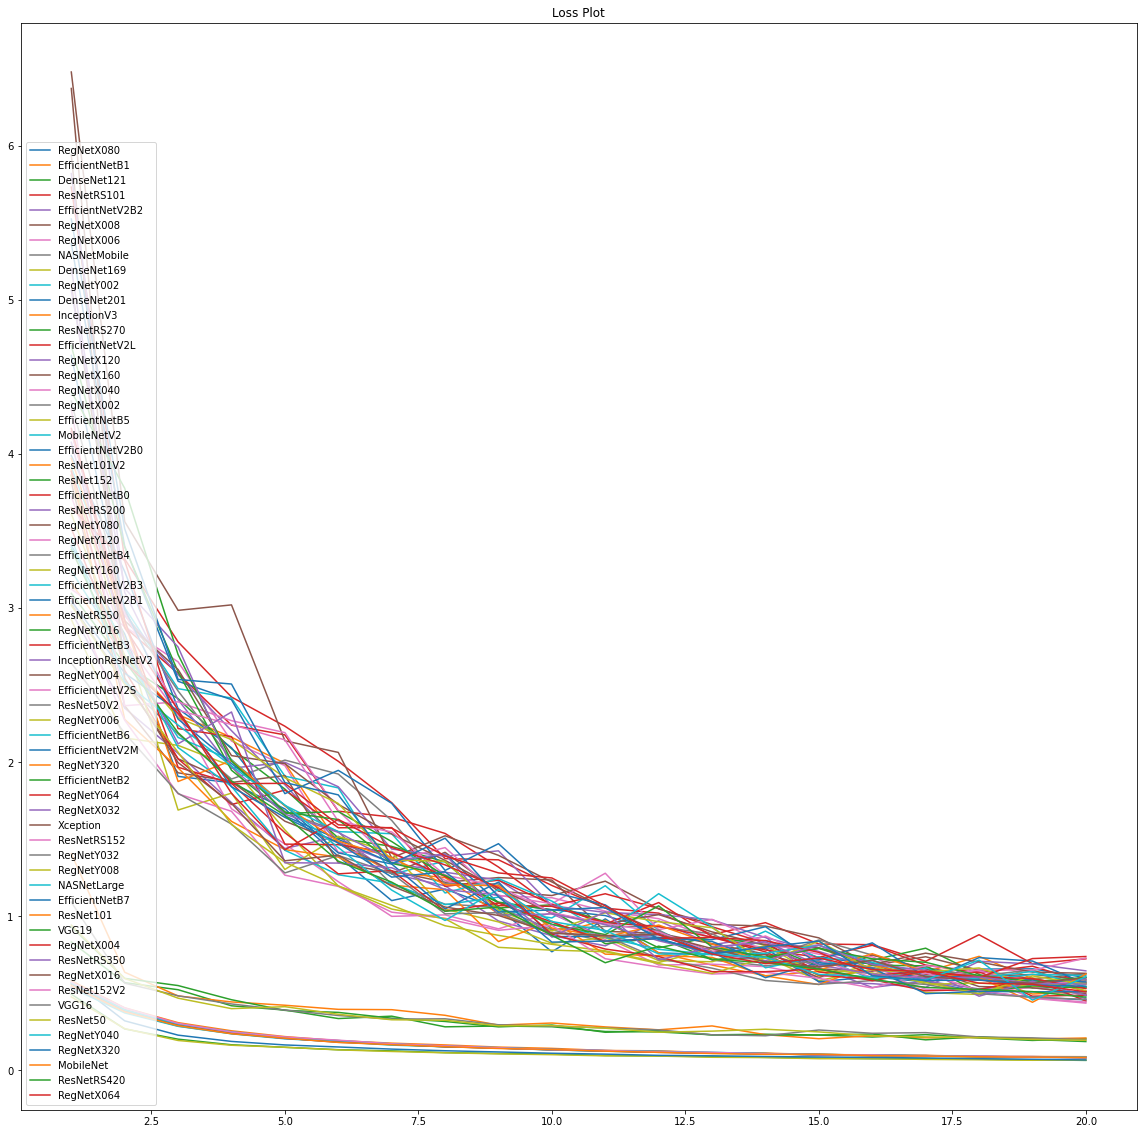

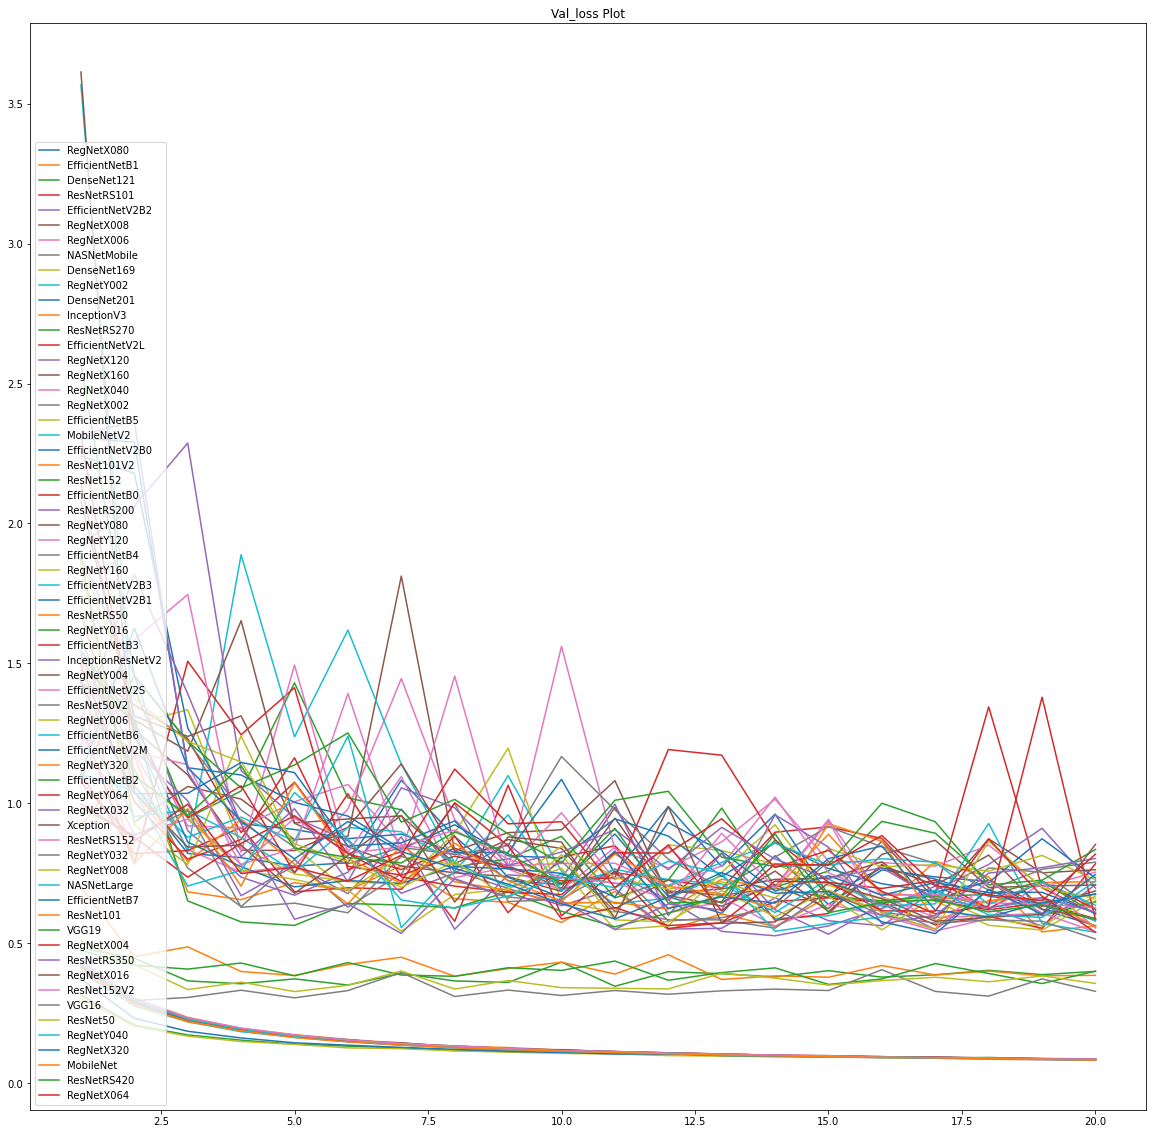

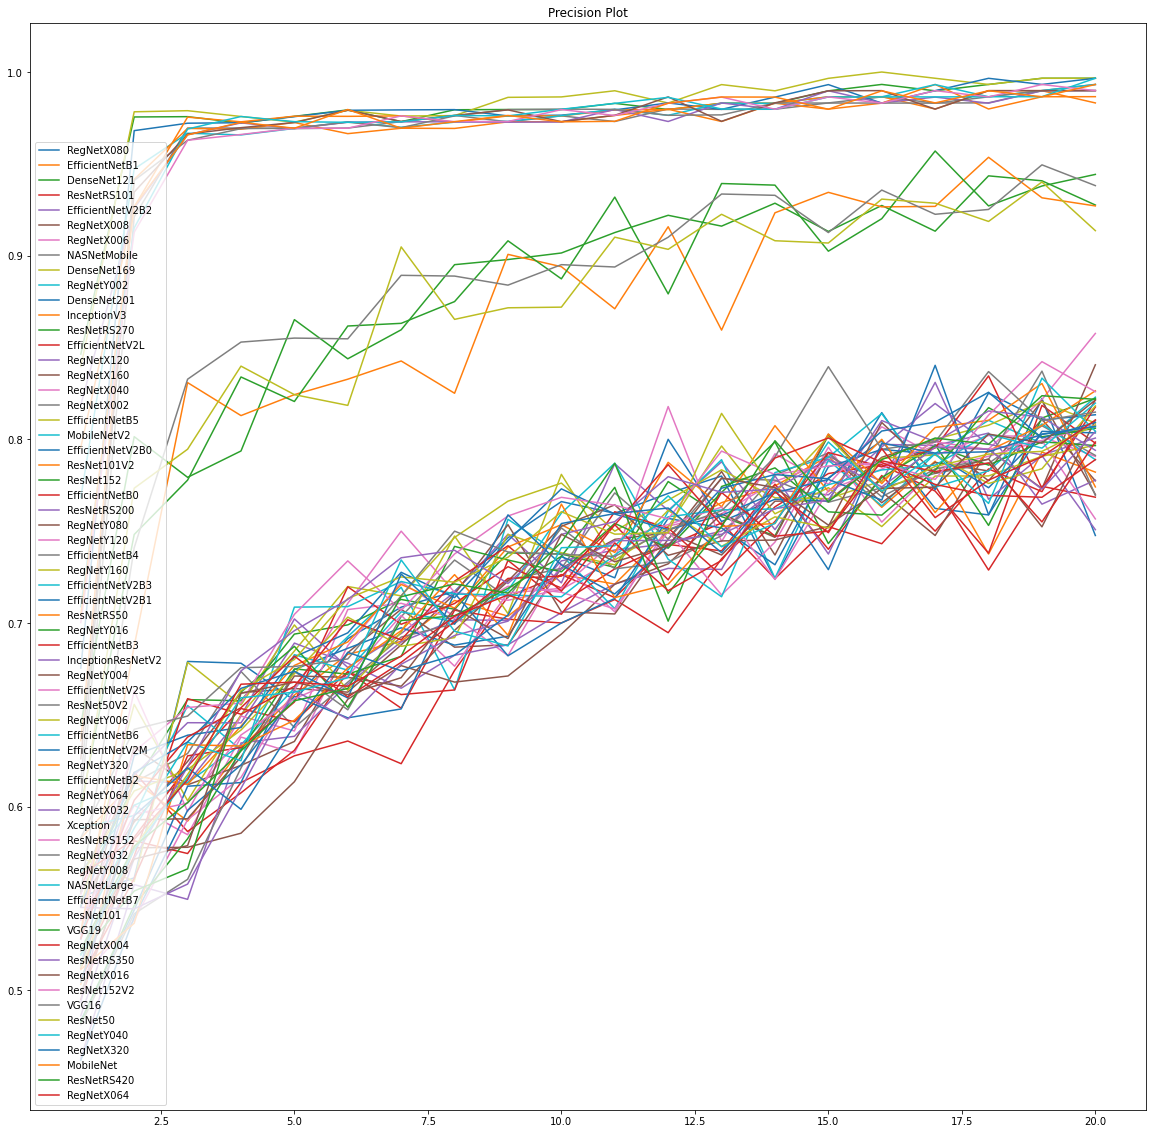

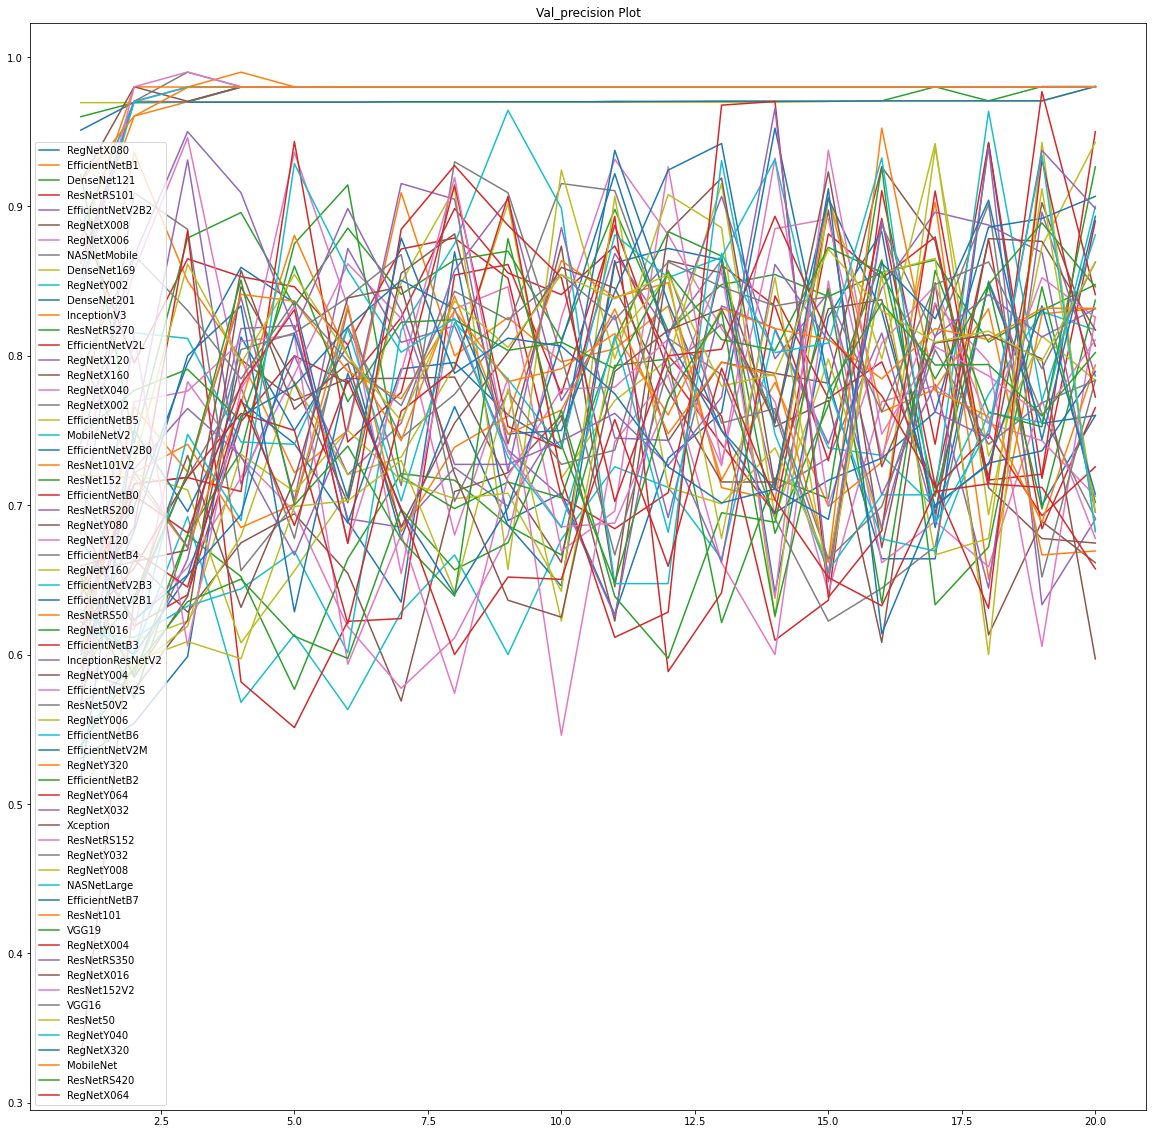

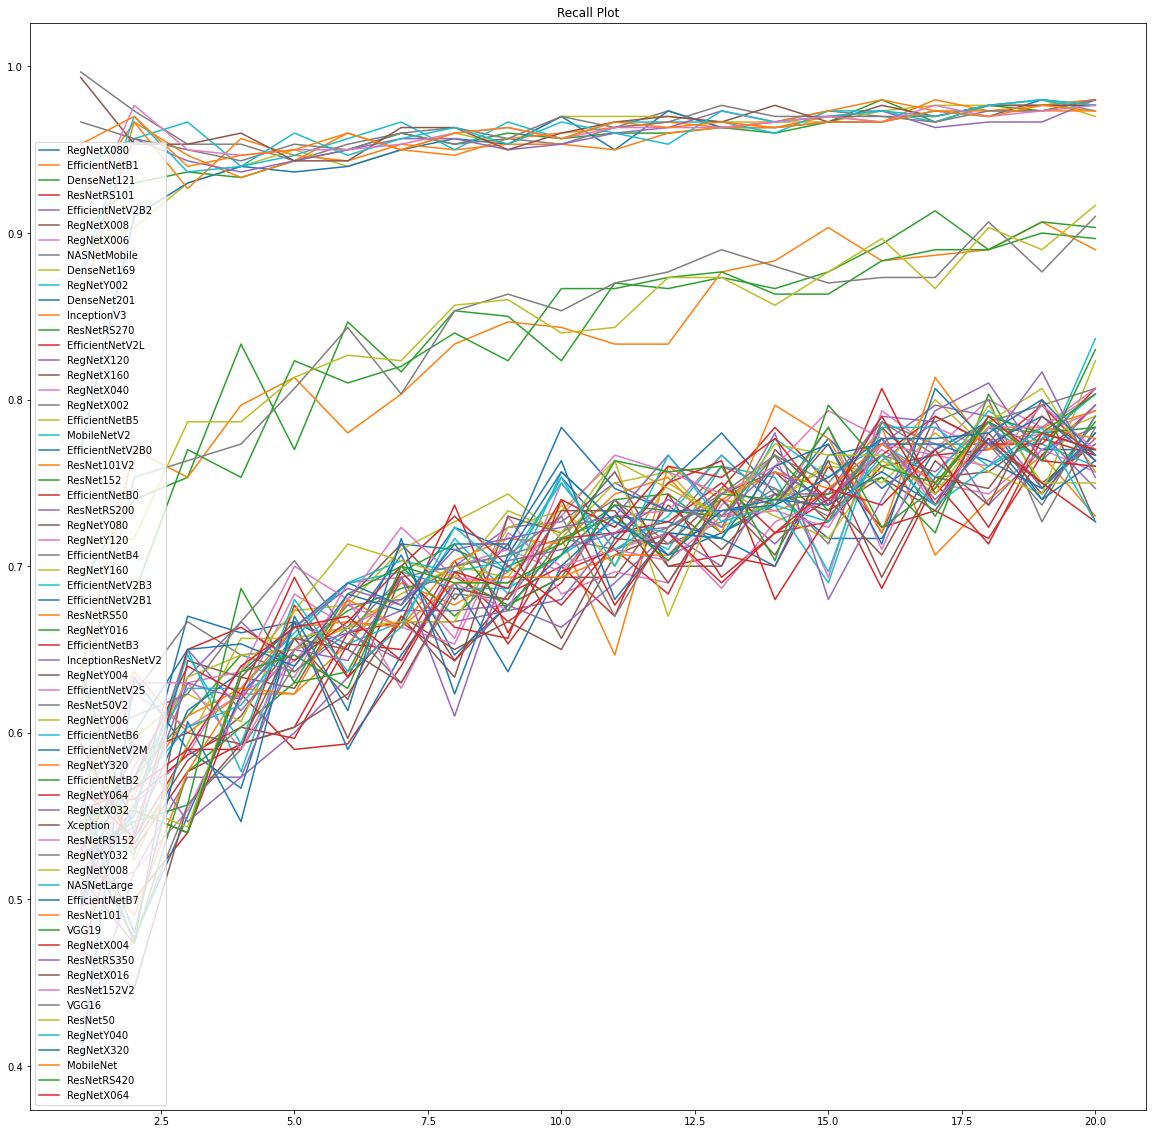

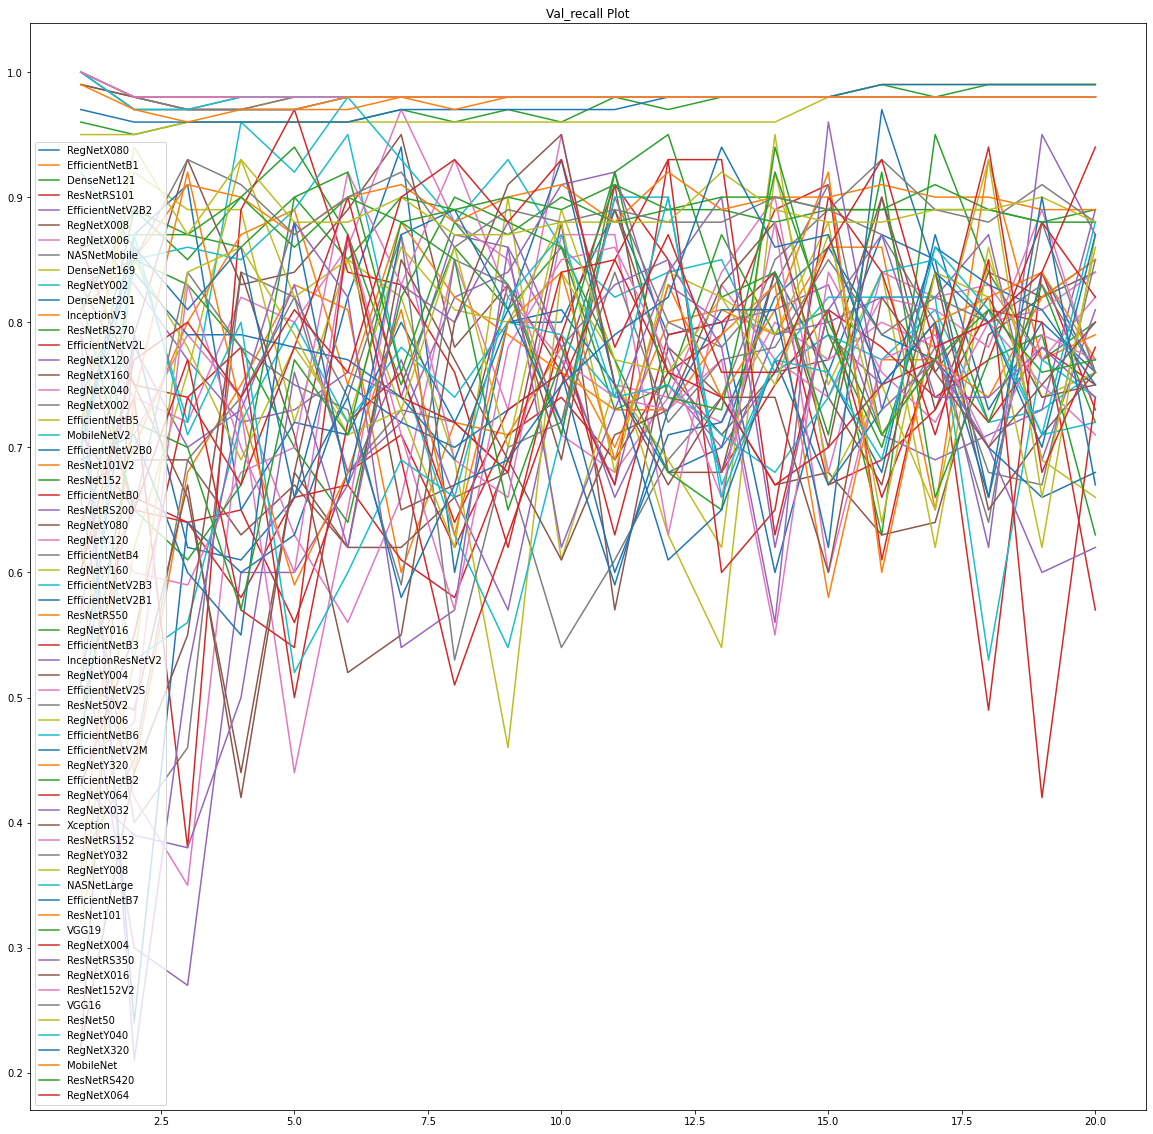

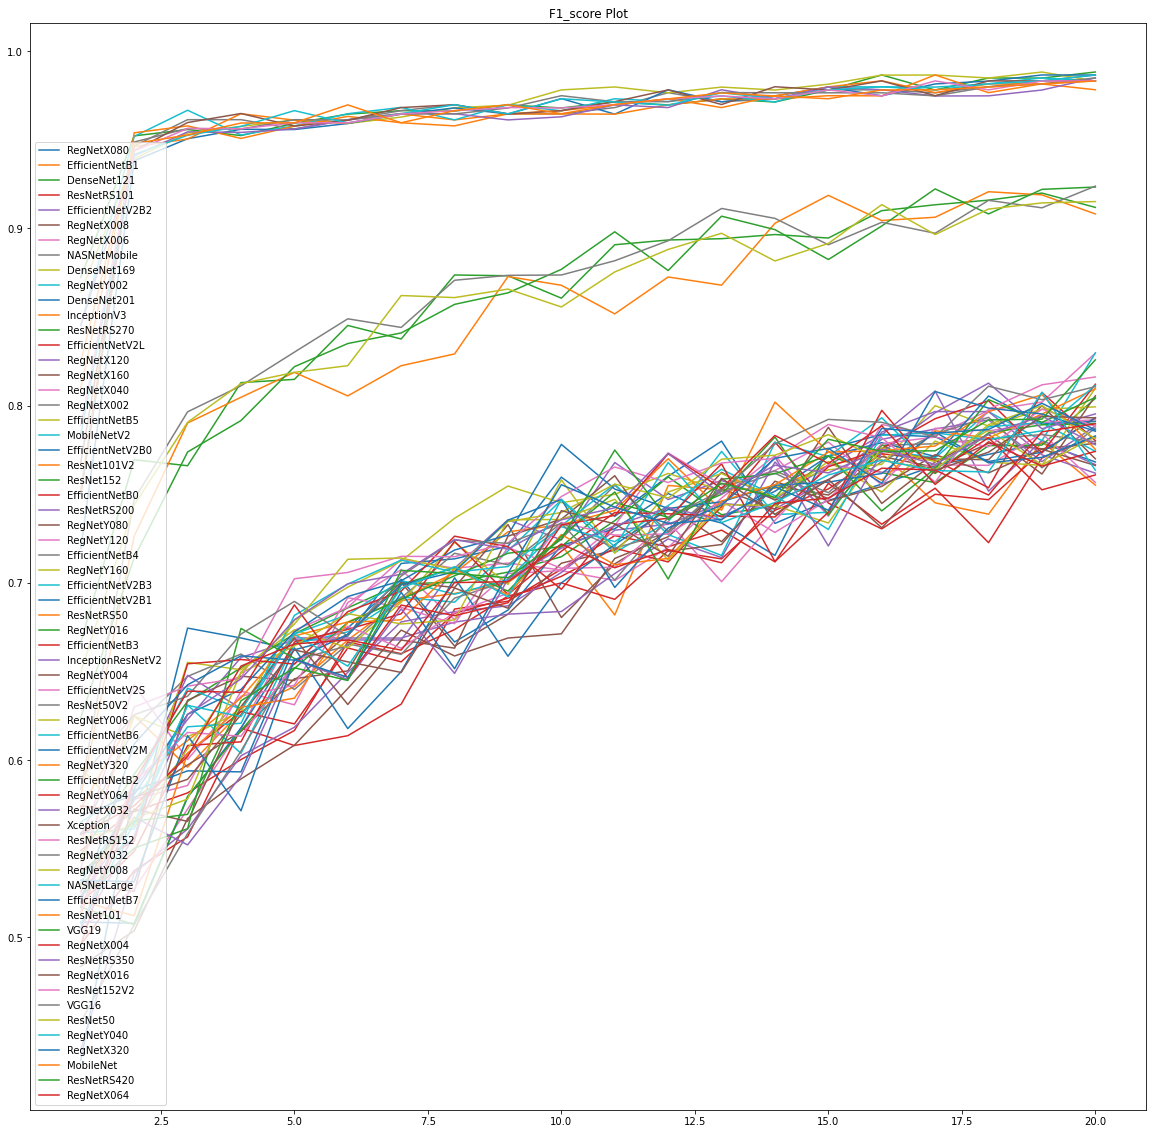

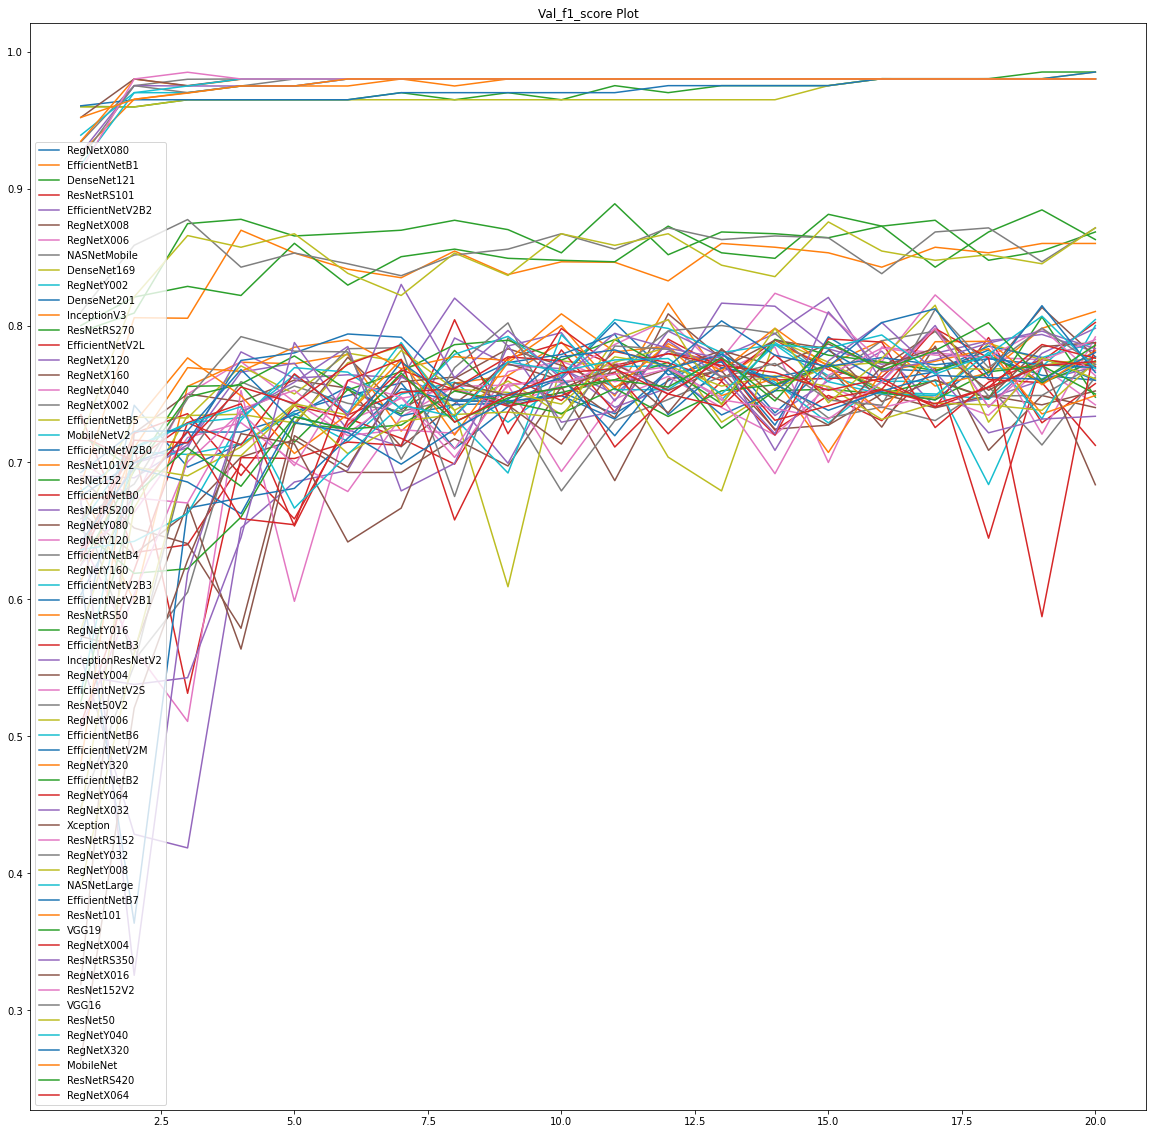

In [ ]:
def plot_curves(history_dict, metric):
    plt.figure(figsize=(20,20))
    for model_name, history in history_dict.items():
        epochs = list(range(1,history.epoch[-1]+2))
        plt.plot(epochs, history.history[metric], label=model_name)
        plt.title(f"{metric.capitalize()} Plot")
        plt.legend(loc="lower left")

plot_curves(history_dict, "loss")
plot_curves(history_dict, "val_loss")
plot_curves(history_dict, "precision")
plot_curves(history_dict, "val_precision")
plot_curves(history_dict, "recall")
plot_curves(history_dict, "val_recall")
plot_curves(history_dict, "f1_score")
plot_curves(history_dict, "val_f1_score")

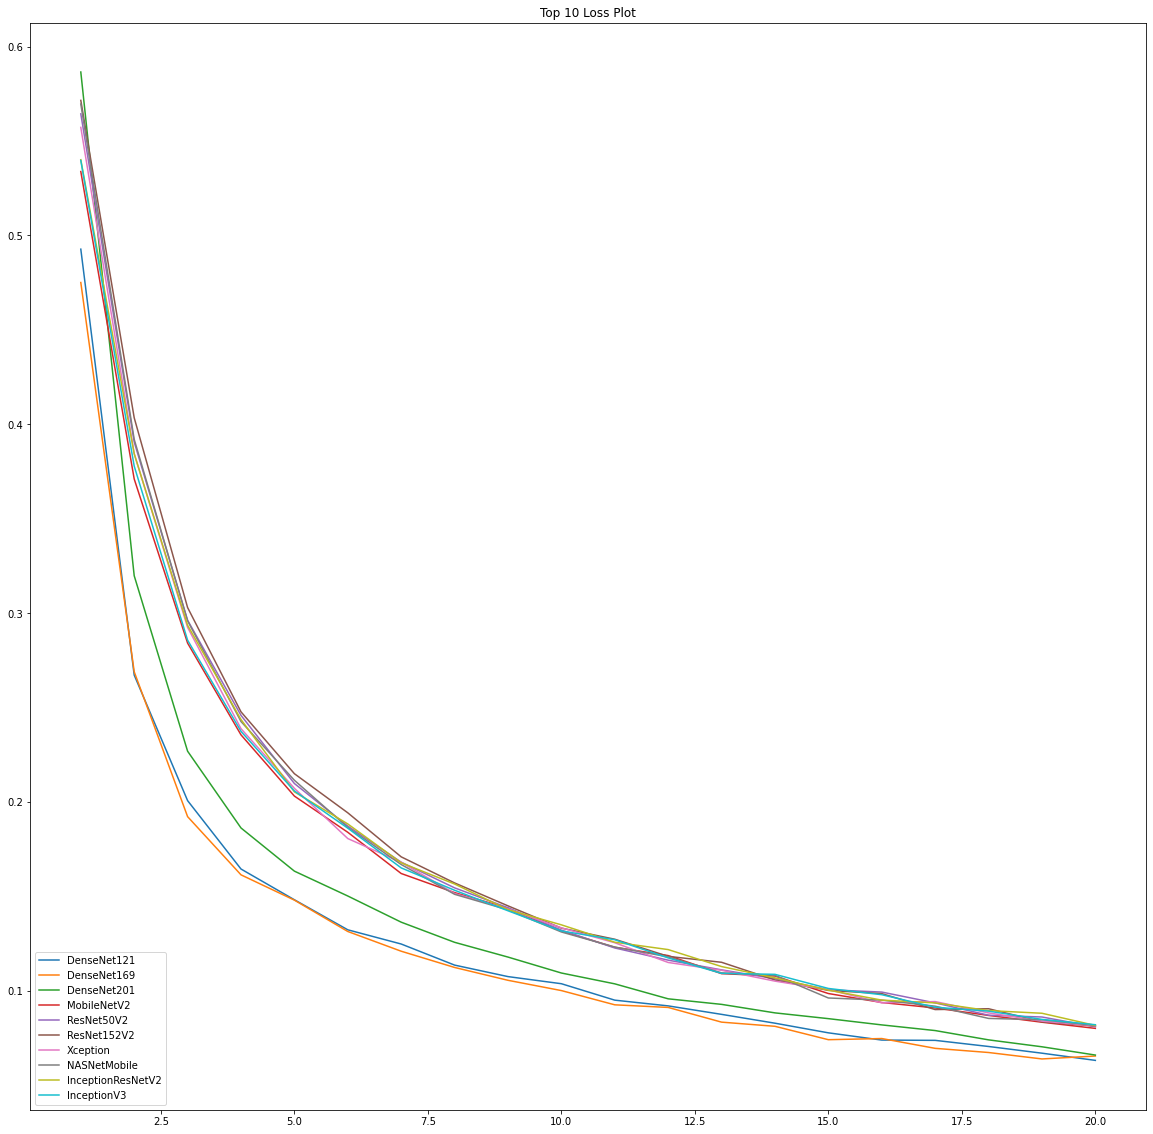

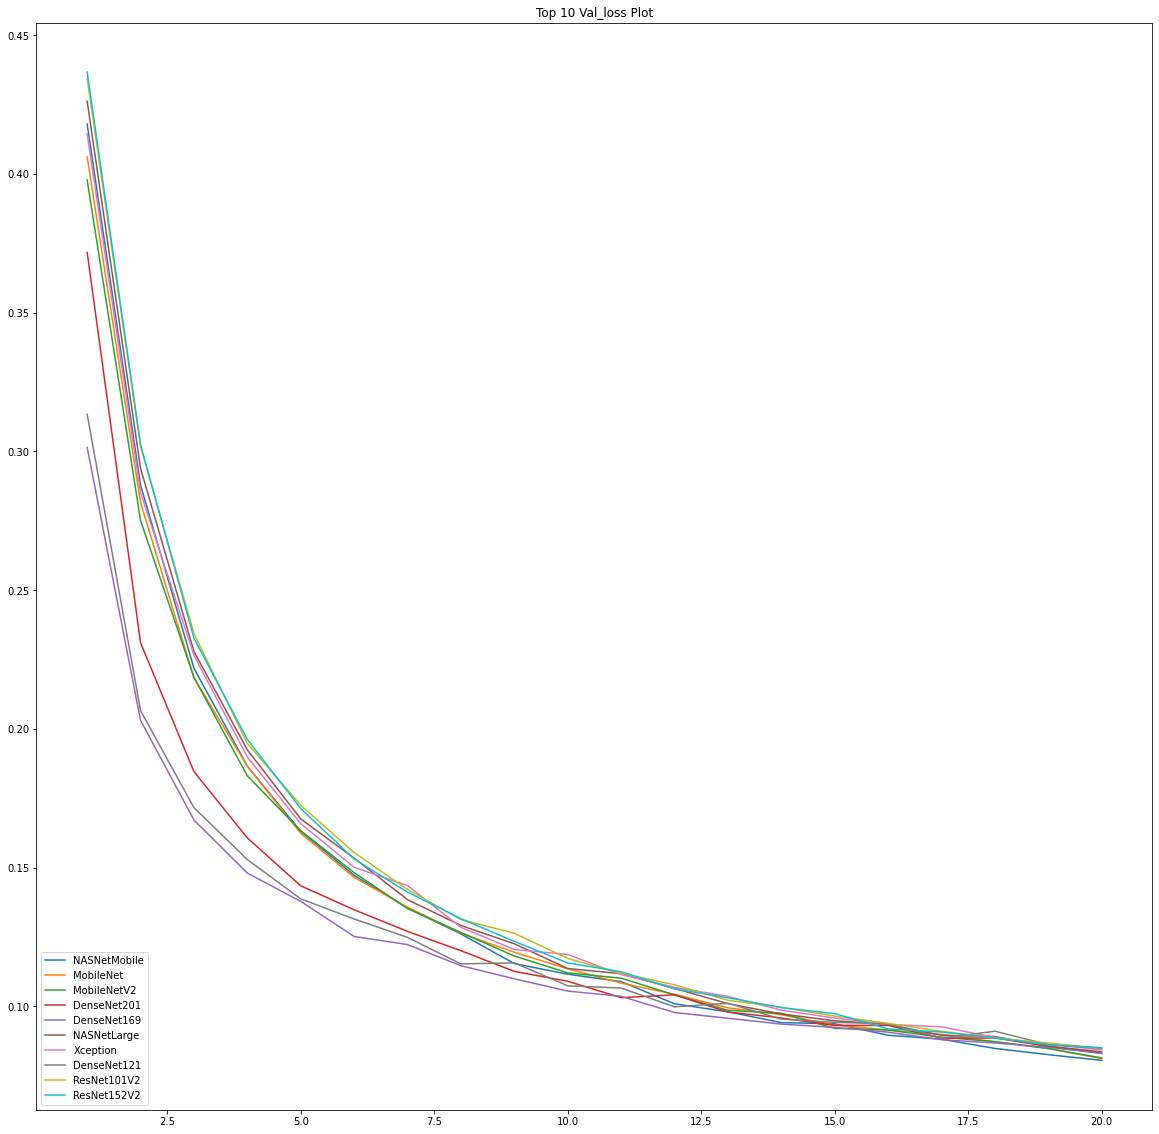

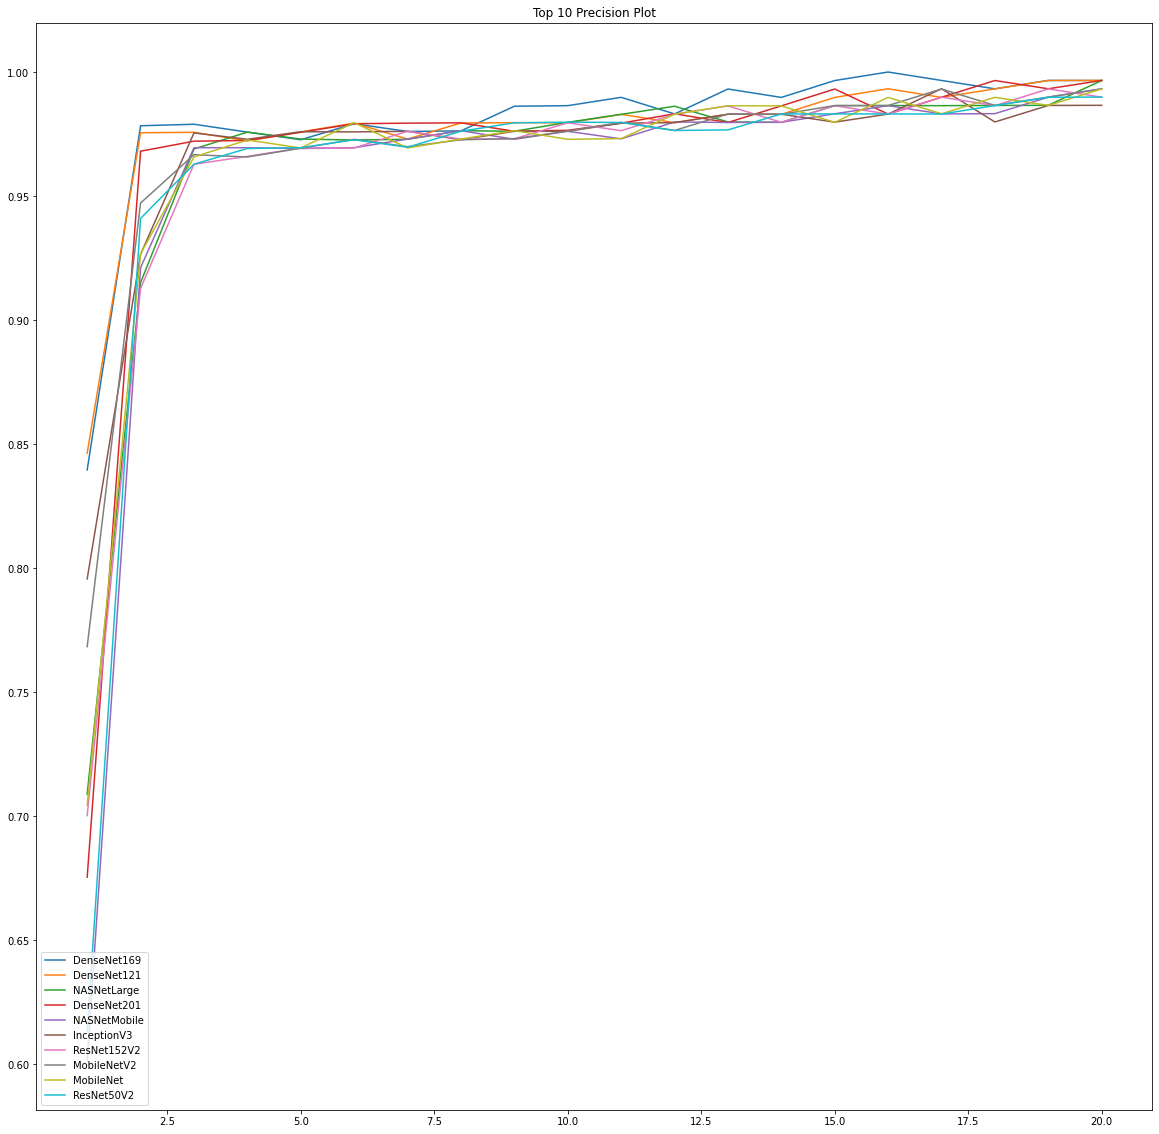

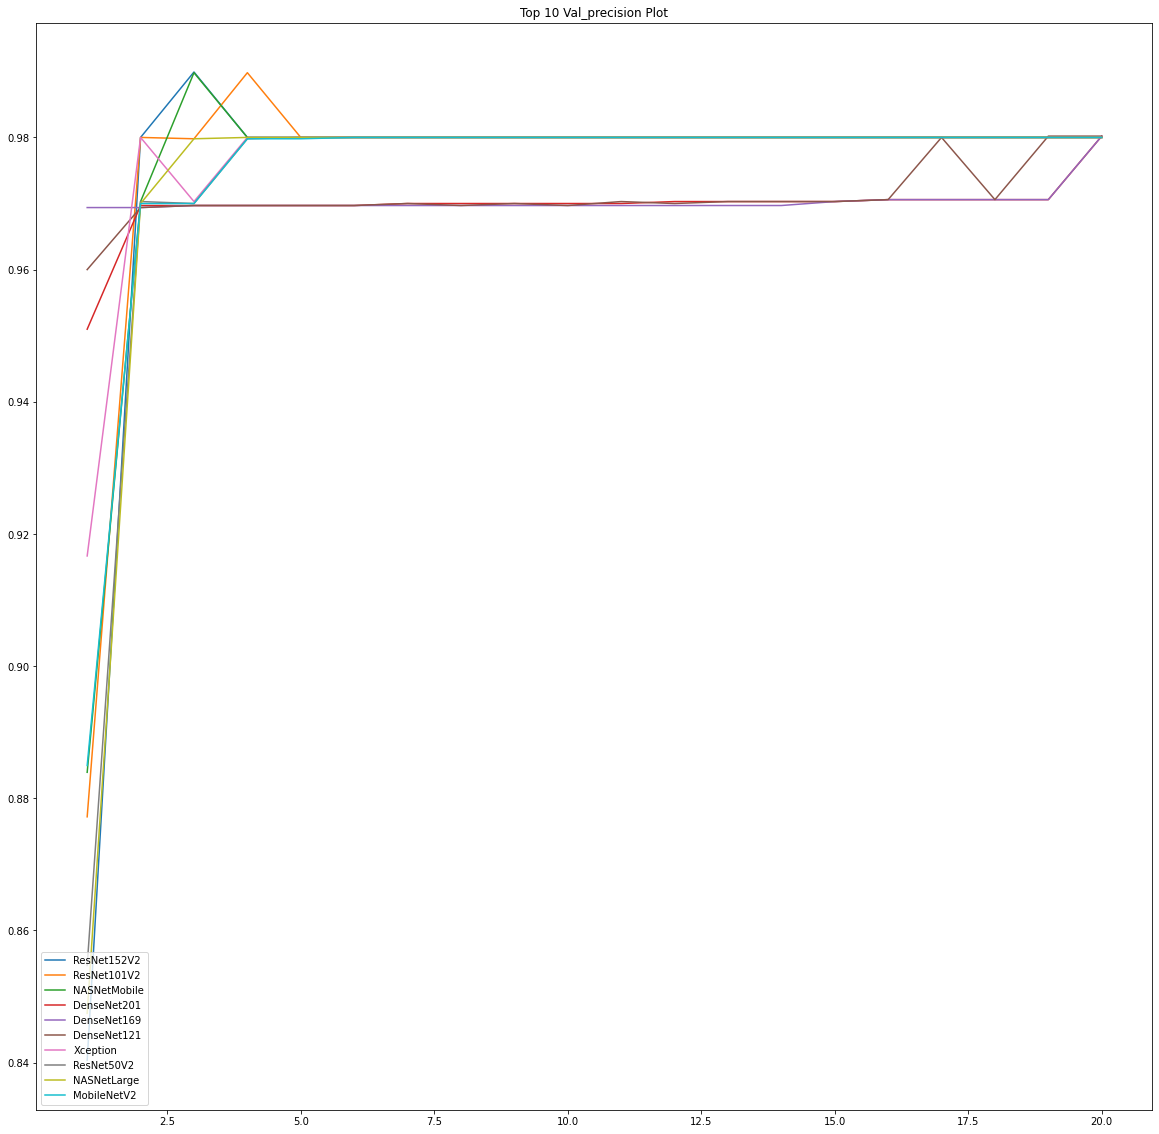

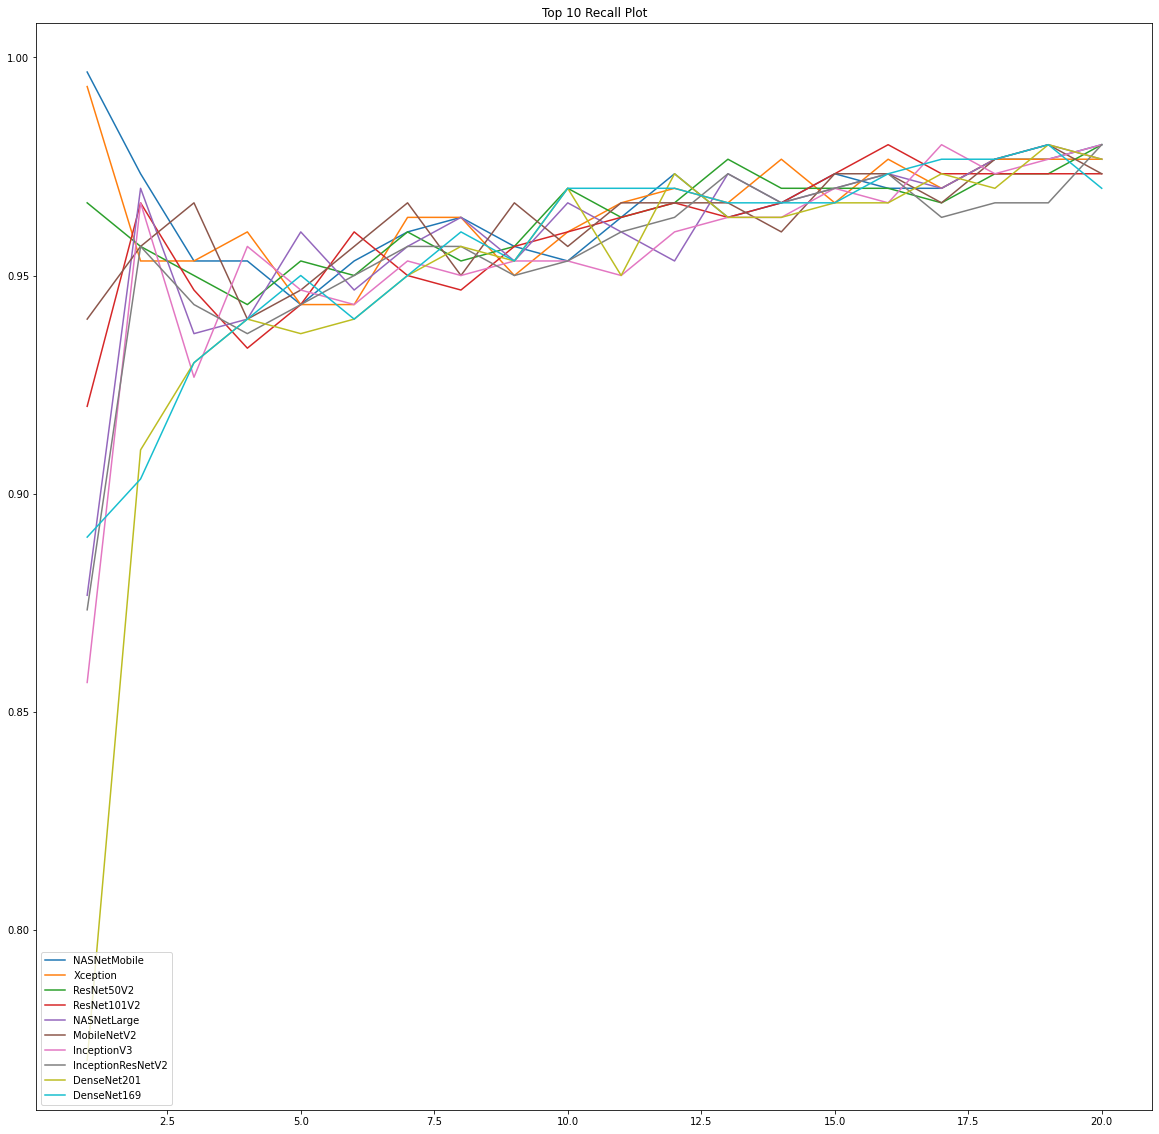

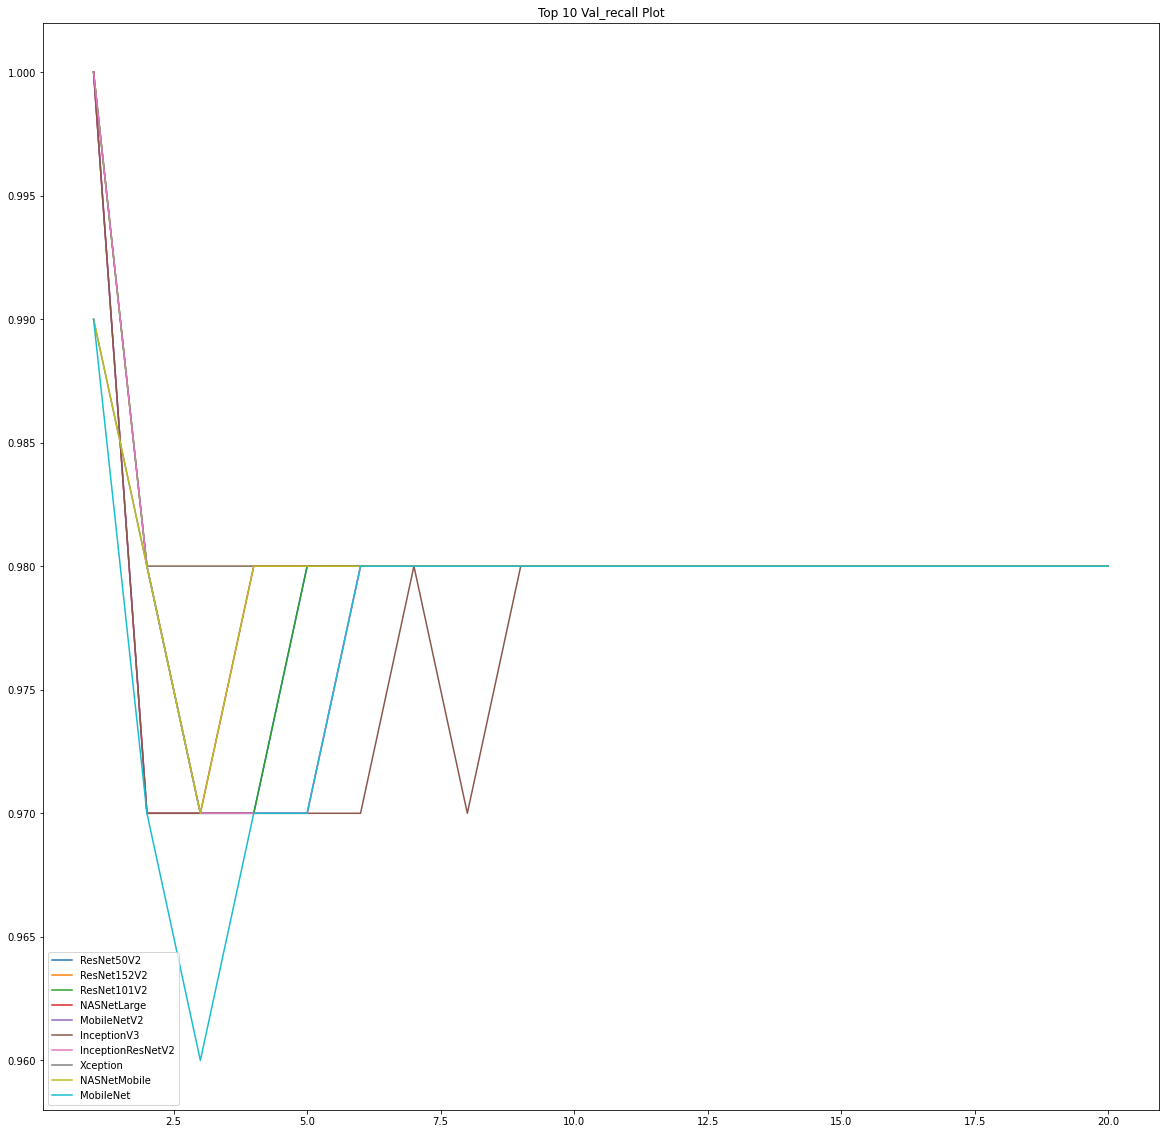

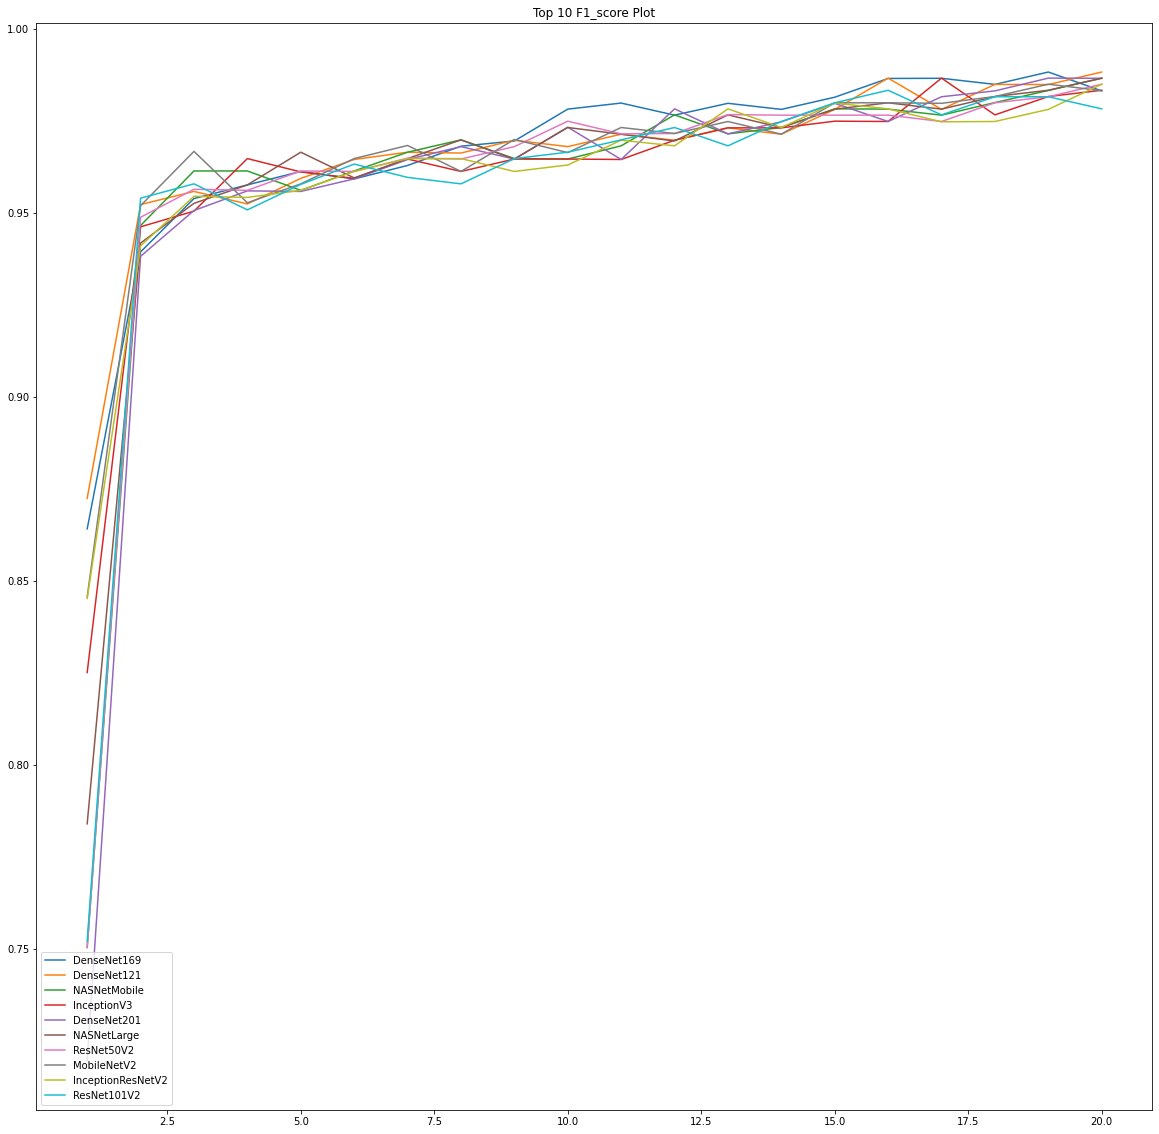

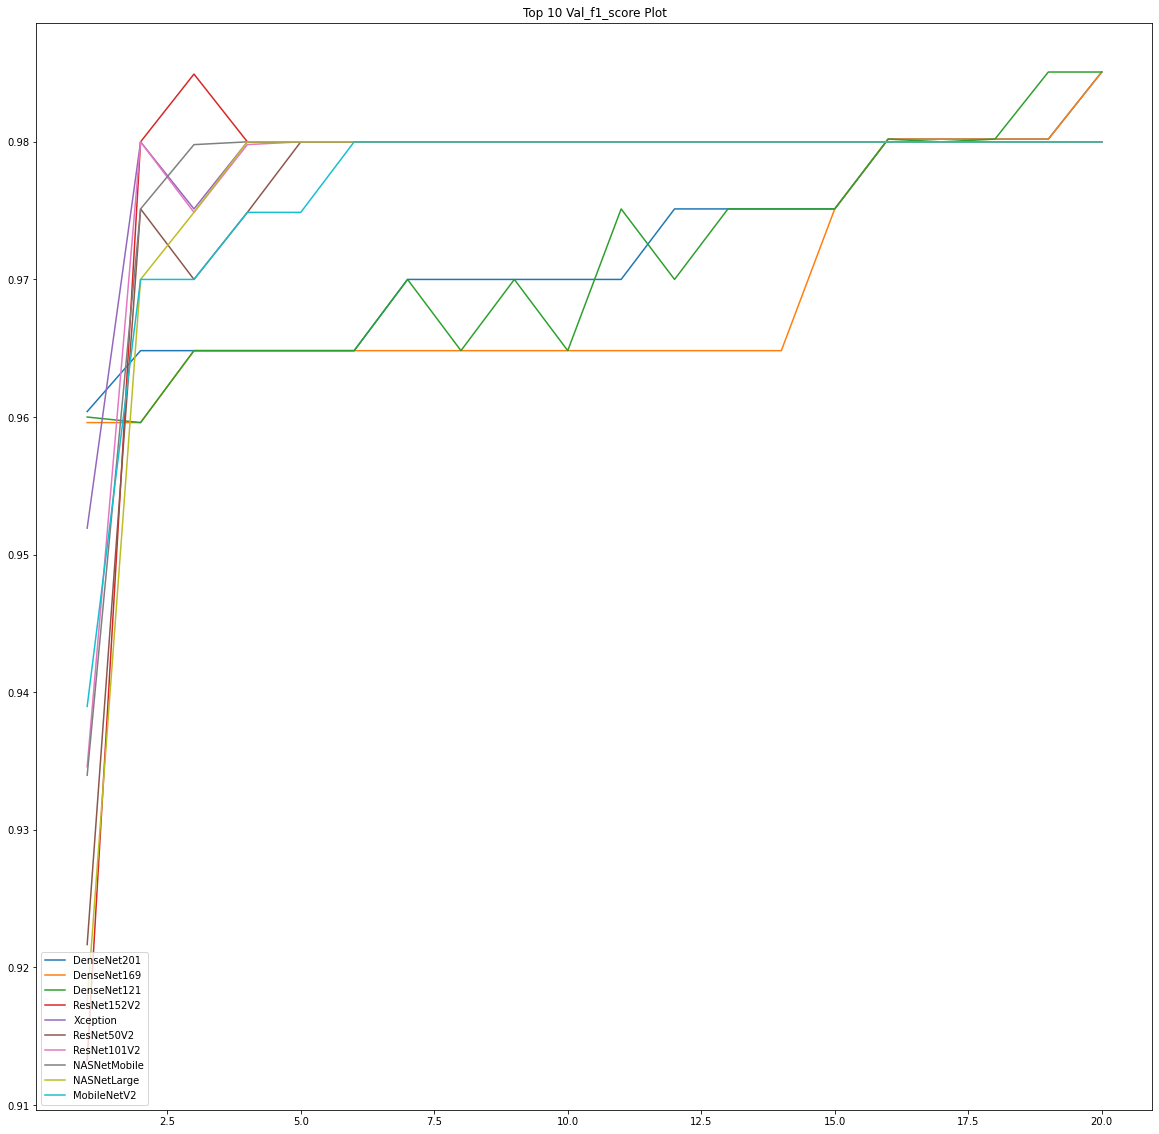

In [ ]:
def top_k_plot_curves(history_dict, metric, k, cmp_fun=max):
    plt.figure(figsize=(20,20))
    curve_list = []
    for model_name, history in history_dict.items():
        cmp = cmp_fun(history.history[metric])
        curve_list.append((cmp,model_name,history))
    curve_list.sort(reverse=(cmp_fun is max))
    for _, model_name, history in curve_list[:k]:
        epochs = list(range(1,history.epoch[-1]+2))
        plt.plot(epochs, history.history[metric], label=model_name)
        plt.title(f"Top {k} {metric.capitalize()} Plot")
        plt.legend(loc="lower left")

top_k_plot_curves(history_dict, "loss", 10, min)
top_k_plot_curves(history_dict, "val_loss", 10, min)
top_k_plot_curves(history_dict, "precision", 10)
top_k_plot_curves(history_dict, "val_precision", 10)
top_k_plot_curves(history_dict, "recall", 10)
top_k_plot_curves(history_dict, "val_recall", 10)
top_k_plot_curves(history_dict, "f1_score", 10)
top_k_plot_curves(history_dict, "val_f1_score", 10)

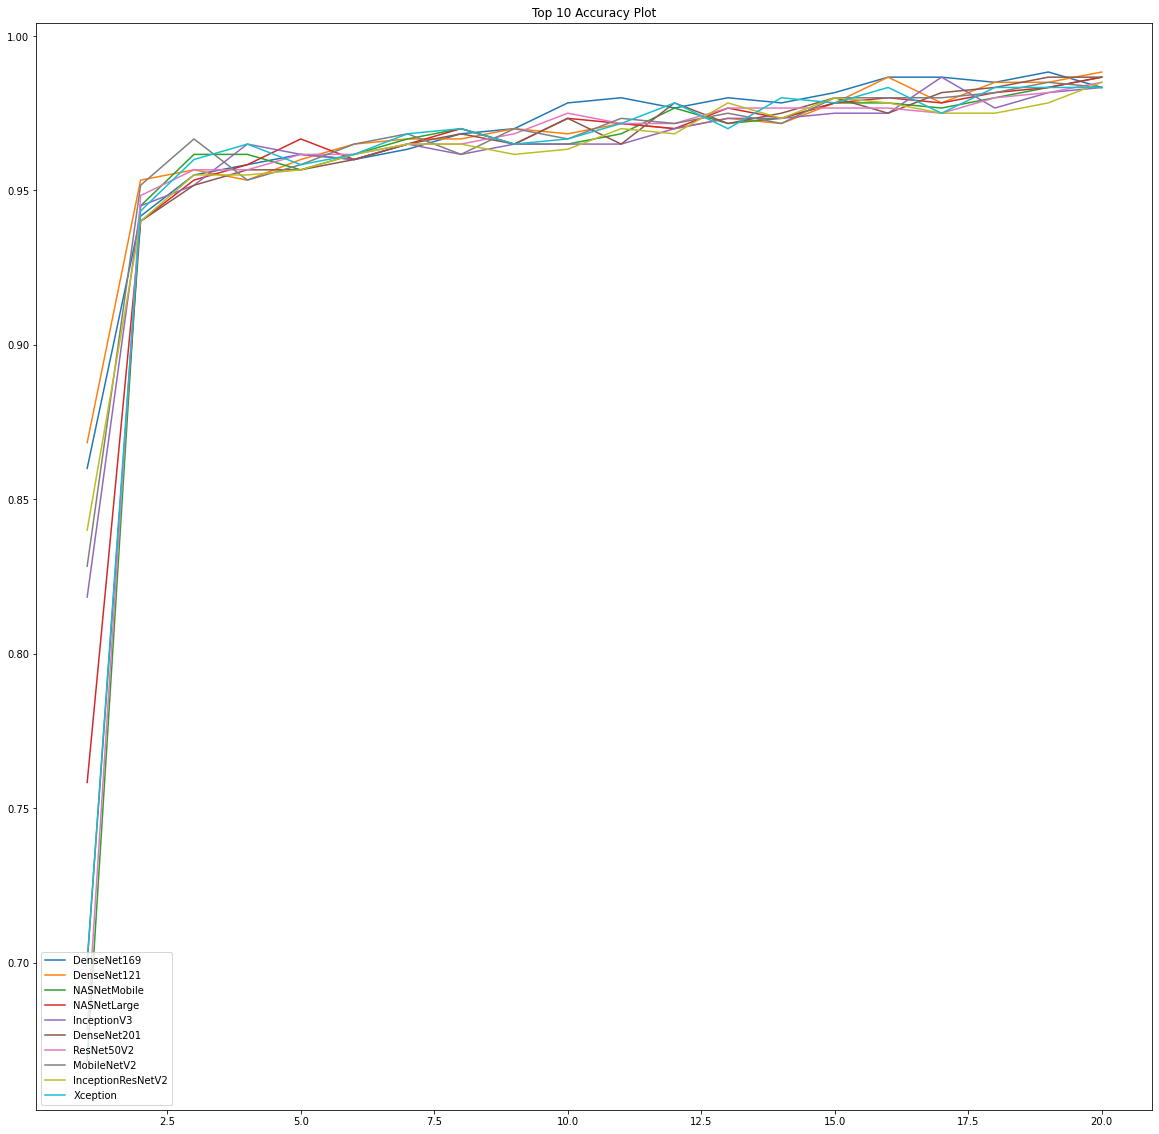

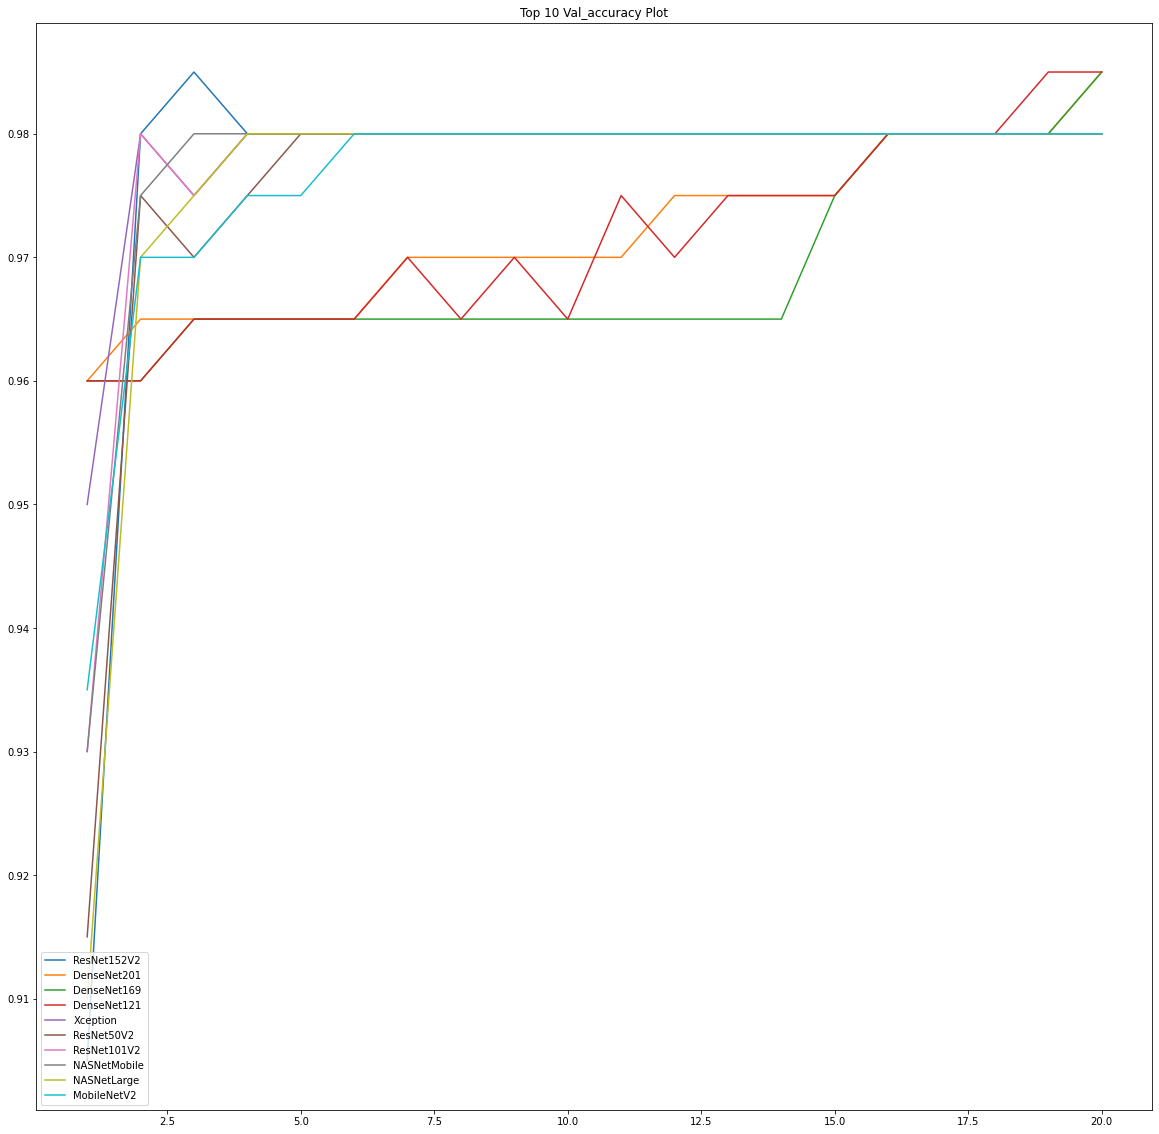

In [ ]:
top_k_plot_curves(history_dict, "accuracy", 10)
top_k_plot_curves(history_dict, "val_accuracy", 10)

In [ ]:
# Evaluate on Test Dataset
error_indices = set()
for model_name, history in history_dict.items():
    with np.load(f"/content/Surface Crack/embeddings/{model_name}.npz") as data:
        metrics = history.model.evaluate(data['test'], test_ds_labels, verbose=0)
        if metrics[-1] > 0.99:
            print("{:<17} loss: {:.4f} - accuracy: {:.4f} - precision: {:.4f} - recall: {:.4f} - f1_score: {:.4f}".format(model_name, *metrics))
            # Get FP and FN indices
            y_pred_thresh = history.model.predict(data['test'], verbose=0) > 0.5
            y_pred_thresh = y_pred_thresh.astype(test_ds_labels.dtype)
            fp_tp = set(np.where(test_ds_labels != y_pred_thresh.flatten())[0])
            print("\tIndices of FP/FN:", *fp_tp)
            error_indices |= fp_tp
error_indices

NASNetMobile      loss: 0.1122 - accuracy: 0.9900 - precision: 0.9804 - recall: 1.0000 - f1_score: 0.9901
	Indices of FP/FN: 99 94
InceptionV3       loss: 0.1229 - accuracy: 0.9900 - precision: 0.9804 - recall: 1.0000 - f1_score: 0.9901
	Indices of FP/FN: 99 94
MobileNetV2       loss: 0.1150 - accuracy: 0.9900 - precision: 0.9804 - recall: 1.0000 - f1_score: 0.9901
	Indices of FP/FN: 99 94
ResNet101V2       loss: 0.1147 - accuracy: 0.9900 - precision: 0.9804 - recall: 1.0000 - f1_score: 0.9901
	Indices of FP/FN: 99 94
InceptionResNetV2 loss: 0.1251 - accuracy: 0.9900 - precision: 0.9804 - recall: 1.0000 - f1_score: 0.9901
	Indices of FP/FN: 99 94
ResNet50V2        loss: 0.1066 - accuracy: 0.9900 - precision: 0.9804 - recall: 1.0000 - f1_score: 0.9901
	Indices of FP/FN: 99 94
Xception          loss: 0.1149 - accuracy: 0.9900 - precision: 0.9804 - recall: 1.0000 - f1_score: 0.9901
	Indices of FP/FN: 99 94
NASNetLarge       loss: 0.1202 - accuracy: 0.9900 - precision: 0.9804 - recall: 1.0

{94, 99}

In [ ]:
error_indices = set()
for model_name, history in history_dict.items():
    with np.load(f"/content/Surface Crack/embeddings/{model_name}.npz") as data:
        metrics = history.model.evaluate(data['val'], test_ds_labels, verbose=0)
        if metrics[-1] > 0.9:
            print("{:<17} loss: {:.4f} - accuracy: {:.4f} - precision: {:.4f} - recall: {:.4f} - f1_score: {:.4f}".format(model_name, *metrics))
            # Get FP and FN indices
            y_pred_thresh = history.model.predict(data['val'], verbose=0) > 0.5
            y_pred_thresh = y_pred_thresh.astype(test_ds_labels.dtype)
            fp_tp = set(np.where(test_ds_labels != y_pred_thresh.flatten())[0])
            print("\tIndices of FP/FN:", *fp_tp)
            error_indices |= fp_tp
error_indices

DenseNet121       loss: 0.0848 - accuracy: 0.9850 - precision: 0.9802 - recall: 0.9900 - f1_score: 0.9851
	Indices of FP/FN: 83 84 195
NASNetMobile      loss: 0.0805 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - f1_score: 0.9800
	Indices of FP/FN: 178 83 84 109
DenseNet169       loss: 0.0830 - accuracy: 0.9850 - precision: 0.9802 - recall: 0.9900 - f1_score: 0.9851
	Indices of FP/FN: 83 84 195
DenseNet201       loss: 0.0830 - accuracy: 0.9850 - precision: 0.9802 - recall: 0.9900 - f1_score: 0.9851
	Indices of FP/FN: 83 84 195
InceptionV3       loss: 0.0853 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - f1_score: 0.9800
	Indices of FP/FN: 178 83 84 109
MobileNetV2       loss: 0.0814 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - f1_score: 0.9800
	Indices of FP/FN: 178 83 84 109
ResNet101V2       loss: 0.0849 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - f1_score: 0.9800
	Indices of FP/FN: 178 83 84 109
InceptionResNetV2 loss: 0.0862 - accura

{83, 84, 109, 178, 195}